# Train Model

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, GlobalAveragePooling1D

## Load data

In [3]:
mnist = tf.keras.datasets.mnist

In [22]:
(mnist_x_train, mnist_y_train) , (mnist_x_test, mnist_y_test) = mnist.load_data()

In [6]:
import seaborn as sns
import random

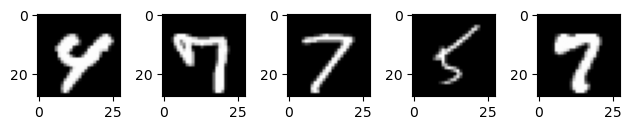

In [9]:
# We select 5 random examples (rows) from the train dataset
random_indexes = random.sample(range(mnist_x_train.shape[0]), 5)
original_images = [mnist_x_train[element] for element in random_indexes]

#Visualizing the orginal images
fig, axes = plt.subplots(nrows=1, ncols=5)

i=0
for ax in axes:
    ax.imshow(original_images[i], cmap ='gist_gray')
    i +=1
fig.tight_layout()


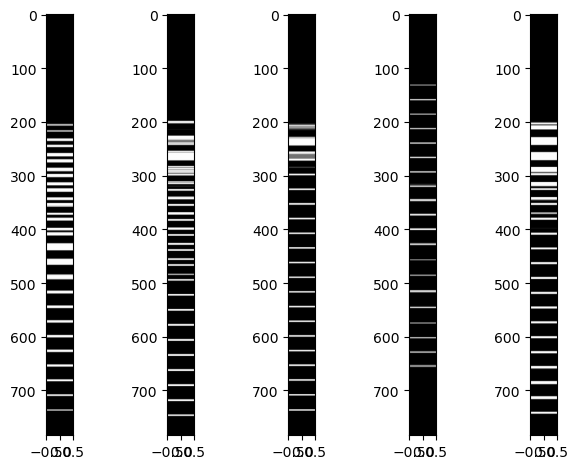

In [17]:
#Visualizing their 784-dimensional array form

fig, axes = plt.subplots(nrows=1, ncols=5)

i=0
for ax in axes:
    ax.imshow(original_images[i].reshape(784,1), aspect = 0.02,  cmap='gist_gray')
    i +=1
fig.tight_layout()

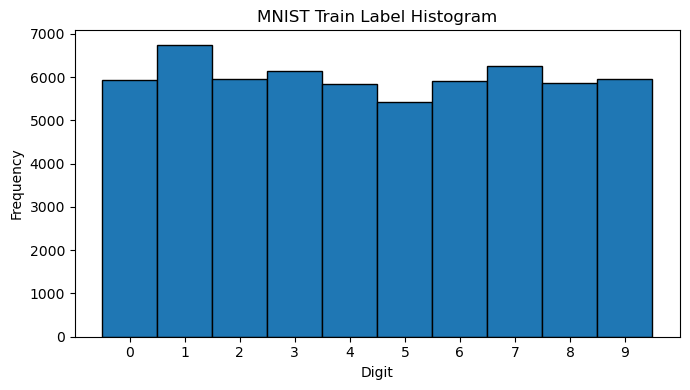

In [19]:
plt.figure(figsize=(7,4))
# Use bin edges centered on digits 0–9
bins = np.arange(-0.5, 10.5, 1)
plt.hist(mnist_y_train, bins=bins, edgecolor='black')
plt.xticks(range(10))
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.title('MNIST Train Label Histogram')
plt.tight_layout()
plt.show()

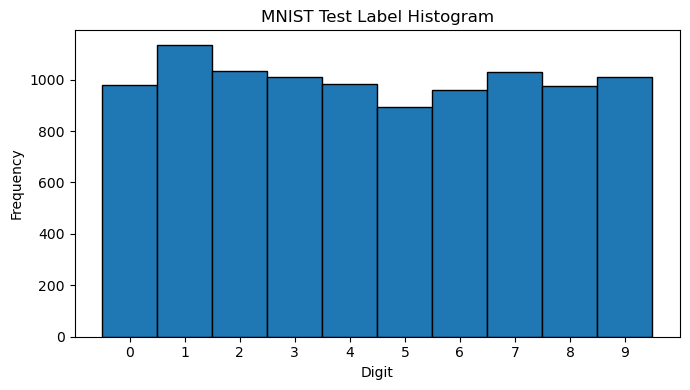

In [21]:
plt.figure(figsize=(7,4))
# Use bin edges centered on digits 0–9
bins = np.arange(-0.5, 10.5, 1)
plt.hist(mnist_y_test, bins=bins, edgecolor='black')
plt.xticks(range(10))
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.title('MNIST Test Label Histogram')
plt.tight_layout()
plt.show()

## Multinomial Logistic Regression
多类别逻辑回归作为线性基线模型，对每个像素特征进行线性分割并输出 10 类概率。

### Linear Discriminant Analysis (LDA)
LDA 通过最大化类间方差与最小化类内方差来寻找投影方向，对多类别问题最多投影到 (C-1) 维（MNIST 为 9 维）。这里直接在展平且简单归一后的像素上训练一个 LDA 模型，作为另一种线性基线对比。

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [29]:
# 3) Build Pipeline: Standardize then Logistic Regression
# with_mean=False reduces memory use on large dense arrays
lg_model = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(
        max_iter=200,
        multi_class="multinomial",
        solver="lbfgs",
    )),
])

In [32]:
lg_train_x = mnist_x_train.reshape((-1, 28 * 28)).astype(np.float32)
lg_test_x = mnist_x_test.reshape((-1, 28 * 28)).astype(np.float32)
lg_model.fit(lg_train_x, mnist_y_train)

d:\anaconda3\envs\ai2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\anaconda3\envs\ai2025\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,False
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [33]:
y_pred = lg_model.predict(lg_test_x)
acc = accuracy_score(mnist_y_test, y_pred)

print(f"Test accuracy: {acc:.4f}")

Test accuracy: 0.9239


In [46]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

# 准备数据：展平并做简单归一 (0-1)，LDA 使用原始数值即可
lda_train_x = mnist_x_train.reshape(-1, 28*28).astype('float32') / 255.0
lda_test_x = mnist_x_test.reshape(-1, 28*28).astype('float32') / 255.0

lda_model = LinearDiscriminantAnalysis(solver='svd')
%time lda_model.fit(lda_train_x, mnist_y_train)
lda_pred = lda_model.predict(lda_test_x)
lda_acc = accuracy_score(mnist_y_test, lda_pred)
print(f"LDA test accuracy: {lda_acc:.4f}")

CPU times: total: 9.95 s
Wall time: 2.04 s
LDA test accuracy: 0.8730


## Neural Network Model
### Train Neural Network Model

In [25]:
mnist_x_train_norm = tf.keras.utils.normalize(mnist_x_train, axis = 1)
mnist_x_test_norm = tf.keras.utils.normalize(mnist_x_test, axis = 1)

In [ ]:
nn_model = tf.keras.models.Sequential()
inputs = tf.keras.Input(shape=mnist_x_train_norm.shape[1:], name="mnist_image")

x = Conv1D(64, 4, activation='relu')(inputs)
x = Conv1D(64, 4, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(128, 4, activation='relu')(x)
x = Conv1D(128, 4, activation='relu')(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.5)(x)

# Flatten is optional after GAP; kept for consistency
x = Flatten()(x)
outputs = Dense(10, activation='softmax', name="class_probs")(x)

nn_model = tf.keras.Model(inputs=inputs, outputs=outputs)
nn_model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

nn_model.summary()

In [ ]:
%%time
nn_model.fit(mnist_x_train_norm, mnist_y_train, epochs = 13)
mnist_val_loss, mnist_val_acc = nn_model.evaluate(mnist_x_test_norm, mnist_y_test)
print(mnist_val_loss, mnist_val_acc)

In [ ]:
nn_model.save('mnist_9917.keras')

## Use model

In [35]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

In [36]:
nn_model = tf.keras.models.load_model('mnist_9917.keras')
nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 25, 64)         │         7,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 22, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 8, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 5, 128)         │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 370,592 (1.41 MB)

 Trainable params: 123,530 (482.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 247,062 (965.09 KB)

In [48]:
def wrong(data, model=None):
    predictions = model.predict(mnist_x_test_norm)
    counter = 0
    for i in range(len(data)):
        if np.argmax(predictions[i]) != data[i]:
            counter += 1
            plt.imshow(mnist_x_test_norm[i], cmap = plt.cm.binary)
            plt.show()
            plt.close()
    print(counter)

def predict(filepath, nn_model=None, lg_model=None, lda_model=None):
    """同时使用神经网络 / 逻辑回归 / LDA 对单张图片进行预测并展示概率分布.

    参数:
        filepath: 图片路径 (将自动读取灰度并缩放到 28x28)
        nn_model: 卷积神经网络模型 (输入形状 28x28)
        lg_model: 多分类逻辑回归 Pipeline (输入展平 784 像素, 未除以 255.0)
        lda_model: 线性判别分析模型 (输入展平 784 像素, 需除以 255.0 与训练一致)
    返回:
        dict 包含三个模型的预测类别与概率数组.
    """
    IMG_SIZE = 28
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img_array is None:
        raise FileNotFoundError(f"Cannot read image: {filepath}")
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

    # 如果需要与训练一致的背景/前景，可选择反色：
    # new_array = 255 - new_array

    nn_digit = lg_digit = lda_digit = None
    nn_probs = lg_probs = lda_probs = None

    # NN 预测 (按行归一化保持一致)
    if nn_model is not None:
        nn_input = tf.keras.utils.normalize(new_array, axis=1).reshape(-1, IMG_SIZE, IMG_SIZE)
        nn_probs = nn_model.predict(nn_input, verbose=0)[0]
        nn_digit = int(np.argmax(nn_probs))

    # 逻辑回归预测 (使用原始像素值 float32)
    if lg_model is not None:
        lg_vector = new_array.reshape(1, -1).astype(np.float32)
        lg_probs = lg_model.predict_proba(lg_vector)[0]
        lg_digit = int(np.argmax(lg_probs))

    # LDA 预测 (与训练时一致，先除以 255.0)
    if lda_model is not None:
        lda_vector = (new_array.reshape(1, -1).astype('float32')) / 255.0
        lda_probs = lda_model.predict_proba(lda_vector)[0]
        lda_digit = int(np.argmax(lda_probs))

    # 可视化布局: 原图 + (1~3) 个概率柱状图
    prob_models = [(nn_probs, 'NN', nn_digit, '#1f77b4'),
                   (lg_probs, 'LogReg', lg_digit, '#ff7f0e'),
                   (lda_probs, 'LDA', lda_digit, '#2ca02c')]
    active = [pm for pm in prob_models if pm[0] is not None]
    cols = len(active) + 1

    plt.figure(figsize=(5 + 3*len(active), 5))
    plt.subplot(1, cols, 1)
    plt.imshow(new_array, cmap='gray_r')
    plt.title('Input')
    plt.axis('off')

    for idx, (probs, name, digit, color) in enumerate(active, start=2):
        plt.subplot(1, cols, idx)
        x = np.arange(10)
        plt.bar(x, probs, color=color)
        plt.xticks(x)
        plt.title(f'{name} (pred={digit})')
    plt.tight_layout()
    plt.show()

    if nn_digit is not None:
        print(f'Neural Network Prediction: {nn_digit}')
    if lg_digit is not None:
        print(f'Logistic Regression Prediction: {lg_digit}')
    if lda_digit is not None:
        print(f'LDA Prediction: {lda_digit}')

    return {
        'nn_digit': nn_digit,
        'lg_digit': lg_digit,
        'lda_digit': lda_digit,
        'nn_probs': nn_probs,
        'lg_probs': lg_probs,
        'lda_probs': lda_probs,
    }

def plot_conv_weights(weights):
    w_min = np.min(weights)
    w_max = np.max(weights)
    num_filters = weights.shape[2]
    num_grids = math.ceil(np.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            img = weights[:, :, i]
            ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [ ]:
wrong(mnist_y_test, model=nn_model) # Counts and shows all the wrong numbers from mnist-test

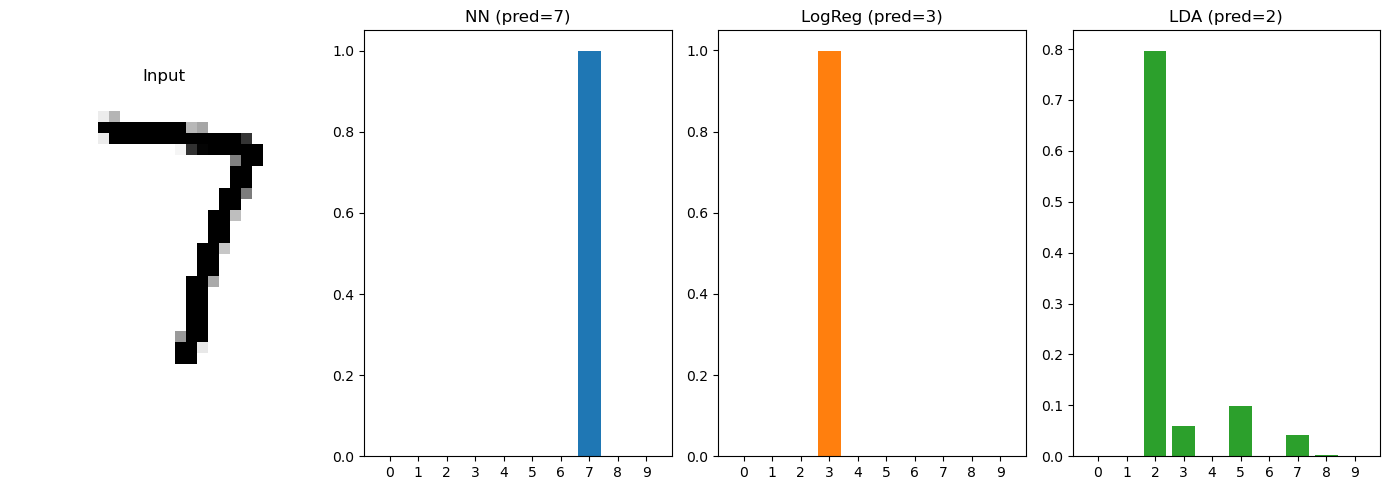

Neural Network Prediction: 7
Logistic Regression Prediction: 3
LDA Prediction: 2


{'nn_digit': 7,
 'lg_digit': 3,
 'lda_digit': 2,
 'nn_probs': array([1.7144077e-24, 3.6099802e-05, 4.2233712e-08, 5.2666140e-13,
        1.0019533e-15, 1.4498921e-22, 2.1263974e-26, 9.9996388e-01,
        4.2902552e-16, 3.0284203e-13], dtype=float32),
 'lg_probs': array([2.97451931e-05, 4.35675166e-15, 6.74474905e-04, 9.99264299e-01,
        2.31162502e-16, 1.52541746e-05, 1.44223021e-07, 7.25752789e-24,
        1.60823434e-05, 4.33722730e-20]),
 'lda_probs': array([3.4751210e-08, 1.7111060e-04, 7.9700285e-01, 5.9199758e-02,
        2.6711121e-05, 9.8554261e-02, 3.1605627e-08, 4.2713553e-02,
        2.2261518e-03, 1.0555439e-04], dtype=float32)}

In [49]:
# 示例调用：同时使用三个模型进行预测
# 确保 nn_model, lg_model, lda_model 已经训练并在当前会话中
predict('number_7.png', nn_model=nn_model, lg_model=lg_model, lda_model=lda_model)

In [50]:
from ipycanvas import Canvas
from ipywidgets import VBox, Button, HBox, Label, HTML
from IPython.display import display
import numpy as np
import cv2
import tensorflow as tf

# 1. 画布 (缩小尺寸 200x200)
canvas = Canvas(width=200, height=200, sync_image_data=True)
canvas.line_width = 18  # 相对尺寸调整

# 初始化白色背景
canvas.fill_style = 'white'
canvas.fill_rect(0, 0, 200, 200)
canvas.stroke_style = 'black'

drawing = False

def handle_mouse_down(x, y):
    global drawing
    drawing = True
    canvas.begin_path()
    canvas.move_to(x, y)

def handle_mouse_move(x, y):
    if drawing:
        canvas.line_to(x, y)
        canvas.stroke()

def handle_mouse_up(x, y):
    global drawing
    drawing = False

canvas.on_mouse_down(handle_mouse_down)
canvas.on_mouse_move(handle_mouse_move)
canvas.on_mouse_up(handle_mouse_up)

# 2. 清空按钮
clear_button = Button(description="Clear Canvas")

def clear_canvas(_):
    canvas.fill_style = 'white'
    canvas.fill_rect(0, 0, 200, 200)

clear_button.on_click(clear_canvas)

# 3. 预测按钮 + 结果 (同时使用神经网络与逻辑回归)
result_label = HTML(value="<h1 style='color:blue; text-align:center;'>Prediction: ?</h1>")

# 假设上面已经训练好 nn_model 与 lg_model
# nn_model 使用归一化的 28x28 输入；lg_model 使用 (784,) 展开后的原始像素并在内部做 StandardScaler

def preprocess_and_predict(_):
    # 1) 获取画布像素 (RGBA)
    img = np.asarray(canvas.get_image_data(), dtype=np.uint8)   # (200, 200, 4)

    # 2) 转灰度
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)                # (200, 200)

    # 3) 缩放成 28x28
    img = cv2.resize(img, (28, 28))

    # 4) 反色（如果训练集是白底黑字，可保留；可按需要注释）
    img = 255 - img

    # ----- 神经网络预测 -----
    nn_input = tf.keras.utils.normalize(img, axis=1).reshape(-1, 28, 28)
    nn_probs = nn_model.predict(nn_input, verbose=0)[0]
    nn_digit = int(np.argmax(nn_probs))

    # ----- 逻辑回归预测 -----
    lg_vector = img.reshape(1, -1).astype(np.float32)
    lg_probs = lg_model.predict_proba(lg_vector)[0]
    lg_digit = int(np.argmax(lg_probs))

    # ----- LDA预测 -----
    lda_vector = (img.reshape(1, -1).astype('float32')) / 255.0
    lda_probs = lda_model.predict_proba(lda_vector)[0]
    lda_digit = int(np.argmax(lda_probs))

    result_label.value = (
        f"<div style='text-align:center;'>"
        f"<h3>Neural Network Prediction: {nn_digit}</h3>"
        f"<h3>Logistic Regression Prediction: {lg_digit}</h3>"
        f"<h3>LDA Prediction: {lda_digit}</h3>"
        f"</div>"
    )

    print('NN probs:', np.round(nn_probs, 3))
    print('LG probs:', np.round(lg_probs, 3))
    print('LDA probs:', np.round(lda_probs, 3))

predict_button = Button(description="Predict")
predict_button.on_click(preprocess_and_predict)

# 4. 显示整个 UI
display(VBox([canvas,
              HBox([predict_button, clear_button]),
              result_label]))
